In [1]:
import pathlib
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import holidays
import ipympl
import nodejs
import datetime as dt

#### Data Paths
All data paths are collected here for easy adjustments.

In [34]:
data_path_hc = r"data/HouseConnection_PxC_2020.json"
data_path_weather = r"data/WeatherForecast_PxC_2020.csv"
data_path_result = r"data/HouseConnection_WeatherForecast_PxC_2020.csv"

## Prepare Data - House Connection Historic Data

In [14]:
# Extract the time series from the json file.
houseconnection_data_raw = pd.read_json(data_path_hc)
houseconnection_data_dict = houseconnection_data_raw["series"]["power"]
houseconnection_data = pd.DataFrame(list(houseconnection_data_dict.items()), columns=['ts', 'kw'])

# Convert timestamp string to datetime
houseconnection_data.ts = pd.to_datetime(houseconnection_data.ts, yearfirst=True)
houseconnection_data = houseconnection_data.set_index("ts", drop=True)

# Resample data on 15 min. 
# houseconnection_data = houseconnection_data.resample('15min').interpolate()
houseconnection_data = houseconnection_data.reset_index()

# Inspect the result.
houseconnection_data.head()

,ts,kw
0,2020-01-01 00:00:00+00:00,5.278736
1,2020-01-01 01:00:00+00:00,5.342686
2,2020-01-01 02:00:00+00:00,5.470356
3,2020-01-01 03:00:00+00:00,5.210809
4,2020-01-01 04:00:00+00:00,5.014649


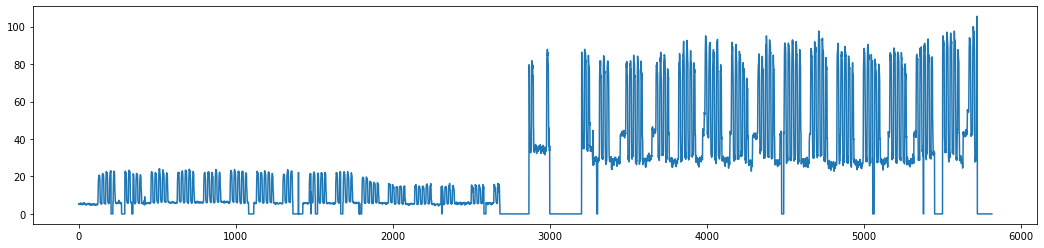

In [15]:
houseconnection_data.kw.plot(figsize=(18, 4))
plt.show()

In [16]:
# Adjust the value ranges for the acquired data did not have consistent scaling.
houseconnection_data.loc[:2700, ('kw')] = houseconnection_data.kw[:2700] * 10
houseconnection_data.loc[2700:, ('kw')] = houseconnection_data.kw[2700:] * 2

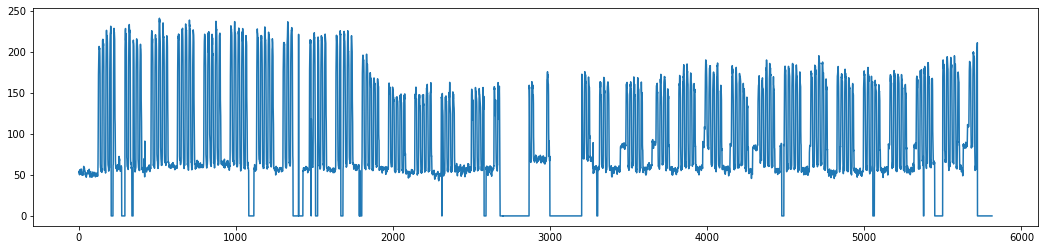

In [17]:
houseconnection_data.kw.plot(figsize=(18, 4))
plt.show()

In [18]:
# Dropping extremely low values as nan.
houseconnection_data.loc[houseconnection_data.kw < 40] = np.nan
print(houseconnection_data.isna().sum())
houseconnection_data = houseconnection_data.dropna()
houseconnection_data = houseconnection_data.reset_index(drop=True)

ts    760
kw    761
dtype: int64


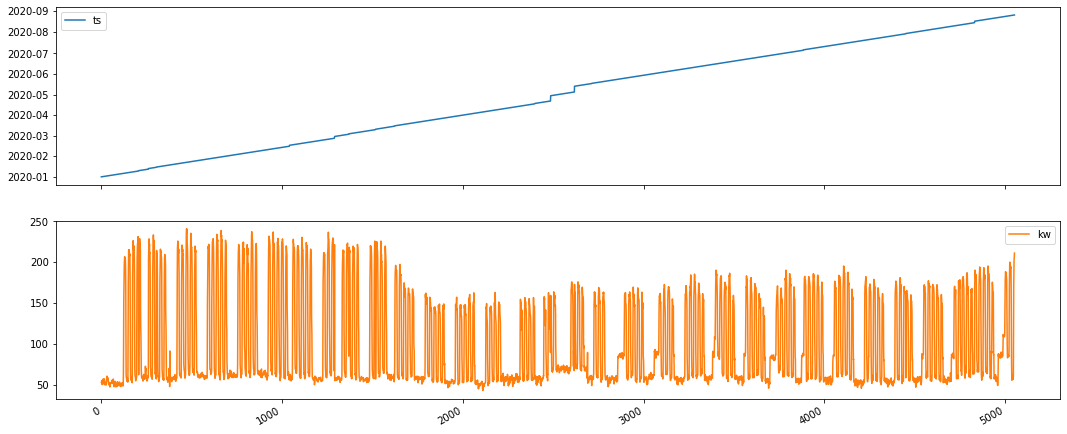

In [19]:
houseconnection_data.plot(subplots=True, figsize=(18, 8))
plt.show()

## Prepare Data - Weather Forecast History

#### Load Weather Forecast Data
As a data source we have a wheather forecast data from a cleaned grib file. The original grib file was obtained from the DWD (Deutscher Wetterdienst), which provides free data on the forecasts it calculates every three hours. Training models on forecasts instead of historical measurements has its pros and cons. The is the format consistency between training data and the data used in the prediction process once the model is in use. 

In [20]:
weather_prediction = pd.read_csv(data_path_weather)
weather_prediction.head()

,year,month,day,hour,minute,solar_global,solar_direct,solar_diff_down,pressure,temp,kw
0,2020,1,18,0,0,0.0,0.0,0.0,998.29560,5.584680,1.86
1,2020,1,18,0,15,0.0,0.0,0.0,998.23379,5.473475,1.86
2,2020,1,18,0,30,0.0,0.0,0.0,998.17198,5.362270,1.86
3,2020,1,18,0,45,0.0,0.0,0.0,998.11017,5.251065,1.86
4,2020,1,18,1,0,0.0,0.0,0.0,998.04836,5.139860,1.86


#### Build UTC Timestamp and Sync Time Resolution
In order to joint the weather forecast data with the house connection data we need a timestamp which exists in both dataframes. This timestamp can be generated form the multiple time columns which exist within the weather forecast data. Moreover the we need to downsample the resolution of the weather data from 15 minutes to hours, for the house connection data exists only in hourly intervals. 

In [21]:
def multi_index_to_timestamp(df):
    return dt.datetime.strptime(df.year+ "-" + df.month+ "-" + df.day + "-" + df.hour+ "-" + df.minute, '%Y-%m-%d-%H-%M')

In [22]:
# Convert multi index (multiple columns making up the time stamp) to a single utc timestamp used as index.
weather_prediction = weather_prediction.reset_index(drop=True)
weather_prediction['ts'] = (
    weather_prediction[['year','month', 'day', 'hour', 'minute']]
    .astype(str)
    .apply(lambda df: multi_index_to_timestamp(df), axis=1)
)
weather_prediction['ts'] = pd.to_datetime(weather_prediction['ts'])
weather_prediction = weather_prediction.set_index('ts', drop=True)
weather_prediction.index = weather_prediction.index.tz_localize('UTC')

# We drop these columns as they would be confused by a subsequent mean sampling operation.
weather_prediction = weather_prediction.drop(columns=['year','month',"day" , "hour", "minute", "kw"])
weather_prediction.head()

,solar_global,solar_direct,solar_diff_down,pressure,temp
ts,,,,,
2020-01-18 00:00:00+00:00,0.0,0.0,0.0,998.29560,5.584680
2020-01-18 00:15:00+00:00,0.0,0.0,0.0,998.23379,5.473475
2020-01-18 00:30:00+00:00,0.0,0.0,0.0,998.17198,5.362270
2020-01-18 00:45:00+00:00,0.0,0.0,0.0,998.11017,5.251065
2020-01-18 01:00:00+00:00,0.0,0.0,0.0,998.04836,5.139860


In [23]:
# Resample wheather data to match the hourly timestamps of the house connection data.
# This is necessary as the weather data has a finer 15 minute resolution. We use mean.
weather_prediction = weather_prediction.resample('H').mean()
weather_prediction = weather_prediction.reset_index()
weather_prediction = weather_prediction.set_index('ts', drop=True)
weather_prediction.head()

,solar_global,solar_direct,solar_diff_down,pressure,temp
ts,,,,,
2020-01-18 00:00:00+00:00,0.0,0.0,0.0,998.202885,5.417873
2020-01-18 01:00:00+00:00,0.0,0.0,0.0,997.961847,5.189848
2020-01-18 02:00:00+00:00,0.0,0.0,0.0,997.639944,5.359470
2020-01-18 03:00:00+00:00,0.0,0.0,0.0,997.096906,5.117276
2020-01-18 04:00:00+00:00,0.0,0.0,0.0,996.381975,4.572529


#### Merge Weather Forecast and House Connection Data

In [24]:
# Merge the weather dataframe with the house connection dataframe using the timestamp.
data_merged = pd.merge_asof(houseconnection_data.copy(), weather_prediction, on='ts')
data_merged.head()

,ts,kw,solar_global,solar_direct,solar_diff_down,pressure,temp
0,2020-01-01 00:00:00+00:00,52.787358,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 01:00:00+00:00,53.426857,NaN,NaN,NaN,NaN,NaN
2,2020-01-01 02:00:00+00:00,54.703557,NaN,NaN,NaN,NaN,NaN
3,2020-01-01 03:00:00+00:00,52.108090,NaN,NaN,NaN,NaN,NaN
4,2020-01-01 04:00:00+00:00,50.146487,NaN,NaN,NaN,NaN,NaN


In [25]:
# Unfortunately the weather data has many nan and a wide timespan where no valid data exists.
data_merged = data_merged[(data_merged.ts <= '2020-06-06 23:00:00+00:00')].dropna()
data_merged.head()

,ts,kw,solar_global,solar_direct,solar_diff_down,pressure,temp
367,2020-01-18 00:00:00+00:00,53.174501,0.0,0.0,0.0,998.202885,5.417873
368,2020-01-18 01:00:00+00:00,52.902479,0.0,0.0,0.0,997.961847,5.189848
369,2020-01-18 02:00:00+00:00,53.652887,0.0,0.0,0.0,997.639944,5.359470
370,2020-01-18 03:00:00+00:00,56.919172,0.0,0.0,0.0,997.096906,5.117276
371,2020-01-18 04:00:00+00:00,58.389289,0.0,0.0,0.0,996.381975,4.572529


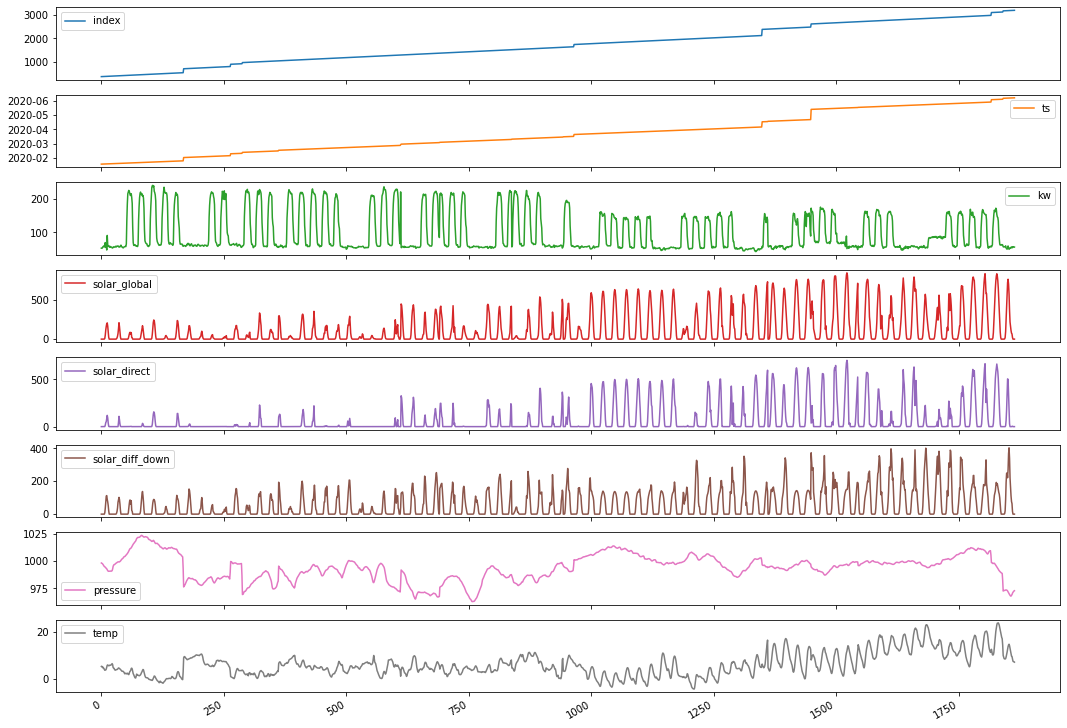

In [26]:
data_merged.reset_index().plot(subplots=True, figsize=(18, 14))
plt.show()

#### Augment Data
We separate the timestamp into multiple columns and add a field indicating holidays. This augmentation makes sense as the energy consumed by an office building largely depends an work day cycles. Having days and hours in individual columns leads to better results in the training process. 

In [27]:
# Create multiple columns for timestamps.
data_merged['year'] = pd.DatetimeIndex(data_merged.ts).year
data_merged['month'] = pd.DatetimeIndex(data_merged.ts).month
data_merged['day'] = pd.DatetimeIndex(data_merged.ts).day
data_merged['hour'] = pd.DatetimeIndex(data_merged.ts).hour
data_merged['minute'] = pd.DatetimeIndex(data_merged.ts).minute
data_merged['weekday'] = data_merged.ts.dt.dayofweek

# The year is not significant as we use only data from 2020 and the minute is to fine a resolution.
data_merged = data_merged.drop(columns = ['year', 'minute'])

In [28]:
# We also want to add a field identifying german holidays (Niedersachsen).
holidays_de_ni = holidays.Germany(prov='NI')
data_merged['holiday'] = data_merged.ts.apply(lambda x: x in holidays_de_ni)
data_merged["holiday"] = data_merged["holiday"].astype(int)

# Finally we use the timestamp as the index again.
data_merged = data_merged.set_index('ts', drop=True)
data_merged.head()

,kw,solar_global,solar_direct,solar_diff_down,pressure,temp,month,day,hour,weekday,holiday
ts,,,,,,,,,,,
2020-01-18 00:00:00+00:00,53.174501,0.0,0.0,0.0,998.202885,5.417873,1,18,0,5,0
2020-01-18 01:00:00+00:00,52.902479,0.0,0.0,0.0,997.961847,5.189848,1,18,1,5,0
2020-01-18 02:00:00+00:00,53.652887,0.0,0.0,0.0,997.639944,5.359470,1,18,2,5,0
2020-01-18 03:00:00+00:00,56.919172,0.0,0.0,0.0,997.096906,5.117276,1,18,3,5,0
2020-01-18 04:00:00+00:00,58.389289,0.0,0.0,0.0,996.381975,4.572529,1,18,4,5,0


#### Inspect the Result and Save Data for later Reuse

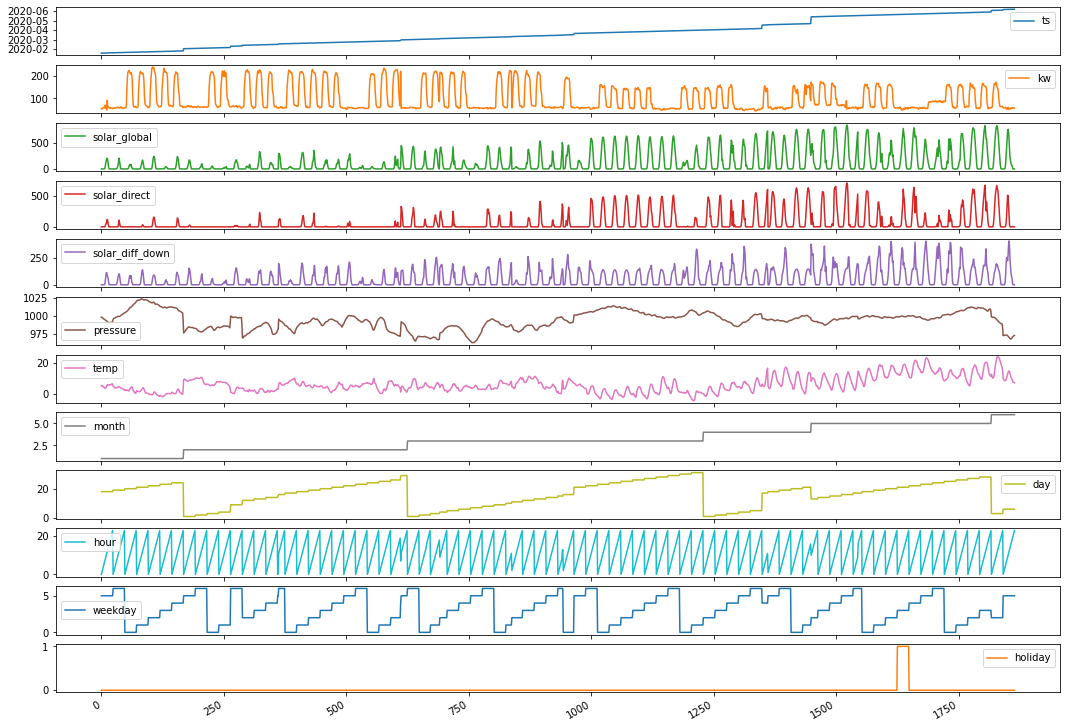

In [29]:
data_merged.reset_index().plot(subplots=True, figsize=(18, 14))
plt.show()

In [30]:
data_merged.isna().sum()

kw                 0
solar_global       0
solar_direct       0
solar_diff_down    0
pressure           0
temp               0
month              0
day                0
hour               0
weekday            0
holiday            0
dtype: int64

In [31]:
data_merged.describe()

,kw,solar_global,solar_direct,solar_diff_down,pressure,temp,month,day,hour,weekday,holiday
count,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000
mean,99.515441,127.633130,69.076527,58.556603,993.964439,6.209543,3.164611,16.328150,11.469705,3.082038,0.012869
std,58.136491,205.666441,145.412011,82.320439,11.723007,5.054703,1.310748,8.518321,6.890021,2.067328,0.112738
min,42.821847,0.000000,0.000000,0.000000,963.052913,-4.233336,1.000000,1.000000,0.000000,0.000000,0.000000
25%,57.116414,0.000000,0.000000,0.000000,986.099237,2.699330,2.000000,9.000000,6.000000,1.000000,0.000000
50%,62.903995,7.393217,0.000000,7.304672,995.210490,5.249456,3.000000,18.000000,11.000000,3.000000,0.000000
75%,146.173403,171.545457,41.603455,111.410817,1000.732625,8.904088,4.000000,23.000000,17.000000,5.000000,0.000000
max,240.937654,853.166227,702.970728,403.541089,1023.334300,23.890712,6.000000,31.000000,23.000000,6.000000,1.000000


In [32]:
# Save final prepared data to file.
data_merged.to_csv(data_path_result)

In [33]:
# Load the file to check if everything is fine.
data_merged = pd.read_csv(data_path_result, index_col='ts', parse_dates=['ts'])
data_merged.head()

,kw,solar_global,solar_direct,solar_diff_down,pressure,temp,month,day,hour,weekday,holiday
ts,,,,,,,,,,,
2020-01-18 00:00:00+00:00,53.174501,0.0,0.0,0.0,998.202885,5.417873,1,18,0,5,0
2020-01-18 01:00:00+00:00,52.902479,0.0,0.0,0.0,997.961847,5.189848,1,18,1,5,0
2020-01-18 02:00:00+00:00,53.652887,0.0,0.0,0.0,997.639944,5.359470,1,18,2,5,0
2020-01-18 03:00:00+00:00,56.919172,0.0,0.0,0.0,997.096906,5.117276,1,18,3,5,0
2020-01-18 04:00:00+00:00,58.389289,0.0,0.0,0.0,996.381975,4.572529,1,18,4,5,0


## Done